
The objective of this file is to generate a list of timestamps for when a passenger
should initiate a trip between floors. 
This file generates a list of passengers, and their trips.
Additionally an array of tuples containing a timestamp in seconds 
from 6AM to around 7PM as well as a passenger id will generated
this indicates that the passenger should initiate a trip.

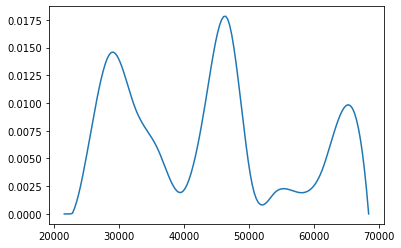

In [1]:
from passenger import *
import numpy as np
from scipy import interpolate
from scipy import integrate
import matplotlib.pyplot as plt
import random


# // -------- Simulation Constants --------

simulation_params = {
    'floors': 80,
    'elevators': 10, 
    'loading_time': 6, # seconds
    'offloading_time': 6, # seconds
    'time_per_floor': 4, # seconds
    'floor_height': 4, # metres
    'dt': 1, # seconds simulation step interval
    'passengers': 1500,

}

hours = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
val =   np.array([0, 30, 75, 50, 30, 10, 50, 90, 15, 10, 10, 20, 50, 0])


h2s = 60 * 60

seconds = hours * 60 * 60
seconds_int = np.linspace(6 * h2s, 19 * h2s, num = 150, endpoint=True)
tk = interpolate.splrep(seconds, val)
val_int = interpolate.splev(seconds_int, tk)
val_int = val_int.clip(min=0)

start = np.min(seconds_int)
end = np.max(seconds_int)

simulation_params['start'] = start
simulation_params['end'] = end

norm_int = val_int / np.sum(val_int)

cum_int = np.cumsum(norm_int) 

plt.plot(seconds_int, norm_int)


The function below generates Passengers as well as the trips that they will make

*Assumptions*:
- Weights are normaly distributed mean: 65kg and standard deviation of 30kg (assuming luggage)
- passengers always start and end at floor 0.
- Passengers can make up to 7 trips in a day and at least 2 (one up and down)


In [2]:

def generatePassengers(n, sp):
    
    weights = np.clip(np.random.normal(65, 30, n), 10, 170)
    trips = np.random.randint(3, 8, n)
    
    select = np.random.randint(0, sp['floors'], np.sum(trips - 2))
    select_index = 0

    out = []

    tripOwner = []

    for i in range(n):
        route = [0] * trips[i]

        tripOwner.extend([i] * (trips[i]-1))

        for y in range (1, trips[i]-1):
            route[y] = select[select_index]
            select_index = select_index + 1

            while(route[y] == route[y-1]):
                route[y] = np.random.randint(1, sp['floors'] - 1, 1)[0]

        # check last route is not 0
        while(route[trips[i]-2] == route[trips[i]-1]):
            route[trips[i]-2] = np.random.randint(1, sp['floors'] - 1, 1)[0]


        out.append(Passenger(weights[i], route))

    return {
        'passengers': out,
        'total_trips': sum(trips) - n,
        'trip_owner': tripOwner
    }


In [3]:
# Assume the building of 10 floors has 200 people

passengers = generatePassengers(simulation_params['passengers'], simulation_params)

print(passengers['total_trips'], len(passengers['trip_owner']))

6094 6094


In [4]:

shuffled_trips = list(passengers['trip_owner']); random.shuffle(shuffled_trips)

shuffled_trips[:20]


[487,
 25,
 248,
 1206,
 637,
 930,
 153,
 939,
 91,
 1498,
 446,
 222,
 1199,
 75,
 1080,
 1007,
 1027,
 342,
 440,
 308]

[23259, 23261, 23281, 23310, 23332, 23361, 23362, 23415, 23446, 23569, 23588, 23591, 23615, 23635, 23641, 23676, 23803, 23850, 23858, 23882, 23883, 23913, 23920, 23969, 23994, 24013, 24069, 24093, 24106, 24173, 24177, 24193, 24201, 24217, 24257, 24317, 24363, 24367, 24384, 24394, 24405, 24416, 24424, 24452, 24457, 24458, 24470, 24481, 24487, 24489]
minute grouping: 3.9


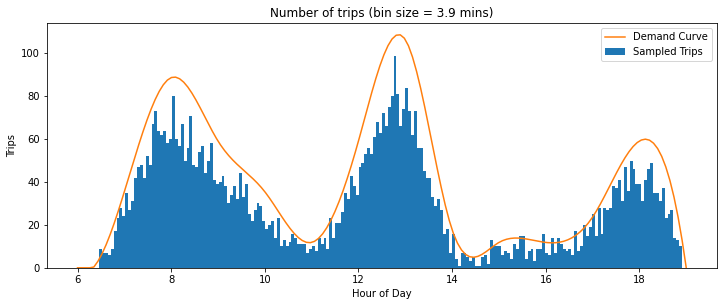

In [5]:
# sample timestamps for each trip

times = [round(np.interp(random.random(), cum_int, seconds_int)) for x in range(passengers['total_trips'])]

# times = times.sort()

times_scale = [x/(60*60) for x in times]

times.sort()
print(times[:50])

bins = 200

min_groups = ((end - start) / bins) / 60


print('minute grouping:', min_groups)


f = plt.figure()
f.set_figwidth(8*1.5)
f.set_figheight(3*1.5)

plt.hist(times_scale, bins)

plt.plot(seconds_int / (60*60), norm_int * passengers['total_trips'])
plt.title('Number of trips (bin size = '+ str(min_groups) + ' mins)')
plt.xlabel('Hour of Day')
plt.ylabel('Trips')

plt.legend(['Demand Curve','Sampled Trips'])


import io
import base64

iobytes = io.BytesIO()
plt.savefig(iobytes, format='jpg')
iobytes.seek(0)
distPlot = base64.b64encode(iobytes.read())



In [7]:
# export data:

import pickle

db = dict({
    'passengers': passengers['passengers'], 
    'traffic_times': times, 
    'traffic_passengers': shuffled_trips,
    'simulation_params': simulation_params,
    'distribution': str(distPlot),
})


filename = "p{}e{}f{}.bin".format(simulation_params['passengers'],simulation_params['elevators'], simulation_params['floors'])

with open(filename, 'wb') as f:
    pickle.dump(db, f)


def secondstotime(sec):
    hours = int(sec / (60*60))
    remainder = sec - (60*60*hours)
    mins = int(remainder / 60)
    remainder = round(remainder - (60*mins))
    return '{:02d}:{:02d}:{:02d}'.format(hours, mins, remainder)

print('len', len(shuffled_trips), len(times))

import pandas as pd

for index, passenger in enumerate(passengers['passengers'][:10]):
    indices = [i for i, passenger_id in enumerate(shuffled_trips) if passenger_id == index]
    timestamps = [secondstotime(times[trip_id]) for trip_id in indices]
    trips = [ '{}-{}'.format(passenger.route[i], passenger.route[i+1]) for i in range(len(passenger.route)) if i < len(passenger.route)-1]
    print('weight:', round(passenger.weight), 'trips:', trips, 'timestamps',  timestamps)


len 6094 6094
weight: 68 trips: ['0-35', '35-0'] timestamps ['09:09:26', '13:28:11']
weight: 107 trips: ['0-20', '20-4', '4-56', '56-41', '41-29', '29-0'] timestamps ['08:46:23', '09:41:12', '11:46:12', '12:05:01', '12:17:06', '18:21:02']
weight: 93 trips: ['0-79', '79-0'] timestamps ['16:00:52', '16:49:47']
weight: 123 trips: ['0-26', '26-10', '10-77', '77-33', '33-0'] timestamps ['12:07:52', '12:32:09', '13:07:13', '13:09:36', '14:02:45']
weight: 10 trips: ['0-34', '34-0'] timestamps ['08:46:27', '17:43:14']
weight: 62 trips: ['0-66', '66-1', '1-0'] timestamps ['07:35:43', '07:36:03', '16:20:14']
weight: 55 trips: ['0-5', '5-79', '79-43', '43-37', '37-0'] timestamps ['08:48:50', '12:58:46', '13:05:34', '17:10:09', '17:50:03']
weight: 102 trips: ['0-70', '70-35', '35-75', '75-24', '24-0'] timestamps ['08:06:53', '09:08:20', '09:24:47', '17:42:55', '18:21:39']
weight: 36 trips: ['0-46', '46-5', '5-32', '32-58', '58-50', '50-0'] timestamps ['07:29:18', '07:34:35', '08:13:53', '08:32:43'